In [1]:
import pandas as pd
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader
from torchtext.vocab import build_vocab_from_iterator
from torchtext.data.utils import get_tokenizer
import torch.optim as optim
import torch.nn.functional as F
import time
import random

In [26]:
RANDOM_SEED=42
MAX_VOCAB=20000
LEARNING_RATE=0.005
BATCH_SIZE=128
EMBEDDING_DIM=128
HIDDEN_DIM=256
NUM_CLASSES=2
NUM_EPOCHS=25
DEVICE=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {DEVICE}")

Using device: cuda


In [3]:
torch.manual_seed(RANDOM_SEED)
torch.backends.cudnn.deterministic = True

In [4]:
tokenizer=get_tokenizer('spacy',language='en_core_web_sm')

In [5]:
def yeild_tokens(data_iter):
    for _, text in data_iter:
        yield tokenizer(text)

In [6]:
class IMDBCSVDataset(Dataset):
    def __init__(self,csv_file):
        self.data=pd.read_csv(csv_file)
        self.data['sentiment'] = self.data['sentiment'].map({'positive': 1, 'negative': 0})
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        review = self.data.iloc[idx]['review']
        sentiment = self.data.iloc[idx]['sentiment']
        return sentiment, review

In [7]:
dataset=IMDBCSVDataset('IMDB Dataset.csv')
train_dataset,test_dataset=torch.utils.data.random_split(dataset, [0.8,0.2])
train_dataset,val_dataset=torch.utils.data.random_split(train_dataset, [0.85,0.15])

In [8]:
print(f"Number of training examples: {len(train_dataset)}")
print(f"Number of validation examples: {len(val_dataset)}")
print(f"Number of testing examples: {len(test_dataset)}")

Number of training examples: 34000
Number of validation examples: 6000
Number of testing examples: 10000


In [9]:
vocab=build_vocab_from_iterator(yeild_tokens(train_dataset),max_tokens=MAX_VOCAB,specials=['<unk>','<pad>'])
vocab.set_default_index(vocab['<unk>'])

In [19]:
def text_pipeline(x):
    tokens=tokenizer(x)
    indexed_tokens=[vocab[token] for token in tokens]
    return torch.tensor(indexed_tokens,dtype=torch.long)
def label_pipeline(x):
    return torch.tensor(x,dtype=torch.long)
def collate_batch(batch):
    text_list=[]
    label_list=[]
    for (_label, _text) in batch:
        label_list.append(label_pipeline(_label))
        processed_text = text_pipeline(_text)
        text_list.append(processed_text)
    padded_texts = pad_sequence(text_list, batch_first=True, padding_value=vocab['<pad>'])
    return padded_texts, torch.tensor(label_list,dtype=torch.long)

In [20]:
train_loader=DataLoader(train_dataset,batch_size=BATCH_SIZE,shuffle=True,collate_fn=collate_batch)
val_loader=DataLoader(val_dataset,batch_size=BATCH_SIZE,shuffle=False,collate_fn=collate_batch)
test_loader=DataLoader(test_dataset,batch_size=BATCH_SIZE,shuffle=False,collate_fn=collate_batch)

In [21]:
class RNN(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim):
        super(RNN, self).__init__()
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_dim,batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, text):
        embedded = self.embedding(text)
        output, hidden = self.rnn(embedded)
        hidden = hidden[-1]
        
        out = self.fc(hidden)
        
        return out

In [22]:
def compute_accuracy(model, data_loader, device):
    with torch.no_grad():
        correct_predictions = 0
        total_predictions = 0
        for features, labels in data_loader:
            features = features.to(device)
            labels = labels.to(device)
            outputs = model(features)
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_predictions += labels.size(0)
    return correct_predictions * 100.00 / total_predictions

In [23]:
torch.manual_seed(RANDOM_SEED)
model = RNN(len(vocab), EMBEDDING_DIM, HIDDEN_DIM, NUM_CLASSES)
model = model.to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()
train_accs=[]
val_accs=[]

In [27]:
start=time.time()
for epoch in range(NUM_EPOCHS):
    model.train()
    for i,(features,labels) in enumerate(train_loader):
        features=features.to(DEVICE)
        labels=labels.to(DEVICE).long()
        optimizer.zero_grad()
        outputs=model(features)
        loss=criterion(outputs,labels)
        loss.backward()
        optimizer.step()
    with torch.no_grad():
        train_acc=compute_accuracy(model,train_loader,DEVICE)
        val_acc=compute_accuracy(model,val_loader,DEVICE)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        print(f'Epoch: {epoch+1}, Loss: {loss.item():.4f}, Train Accuracy: {train_acc:.2f}%, Validation Accuracy: {val_acc:.2f}%')
    print(f'Time elapsed: {time.time()-start:.2f} seconds')


print('Test Accuracy: {:.2f}%'.format(compute_accuracy(model,test_loader,DEVICE)))

Epoch: 1, Loss: 0.7370, Train Accuracy: 50.04%, Validation Accuracy: 49.28%
Time elapsed: 95.33 seconds
Epoch: 2, Loss: 0.7252, Train Accuracy: 50.00%, Validation Accuracy: 49.18%
Time elapsed: 188.76 seconds
Epoch: 3, Loss: 0.6787, Train Accuracy: 50.08%, Validation Accuracy: 50.75%
Time elapsed: 282.00 seconds
Epoch: 4, Loss: 0.6813, Train Accuracy: 50.18%, Validation Accuracy: 50.70%
Time elapsed: 375.09 seconds
Epoch: 5, Loss: 0.7017, Train Accuracy: 50.13%, Validation Accuracy: 49.25%
Time elapsed: 468.52 seconds
Epoch: 6, Loss: 0.6915, Train Accuracy: 50.16%, Validation Accuracy: 50.68%
Time elapsed: 561.95 seconds
Epoch: 7, Loss: 0.7161, Train Accuracy: 50.14%, Validation Accuracy: 49.30%
Time elapsed: 655.44 seconds
Epoch: 8, Loss: 0.6882, Train Accuracy: 50.19%, Validation Accuracy: 49.23%
Time elapsed: 748.86 seconds
Epoch: 9, Loss: 0.6977, Train Accuracy: 50.23%, Validation Accuracy: 49.25%
Time elapsed: 841.79 seconds
Epoch: 10, Loss: 0.7021, Train Accuracy: 50.29%, Validat

Text(0.5, 1.0, 'Training and Validation Loss over Epochs')

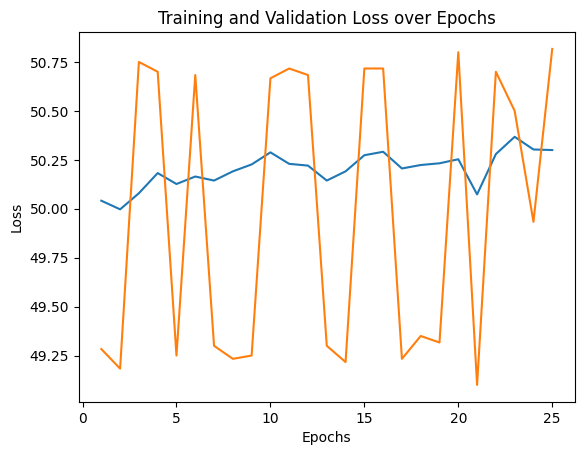

In [30]:
import matplotlib.pyplot as plt
plt.plot(range(1, NUM_EPOCHS + 1), train_accs[15:], label='Training Loss')
plt.plot(range(1, NUM_EPOCHS + 1), val_accs[15:], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')